# Способы отрисовки поверхностей

## Расчеты SES поверхностей

Вот тут обозрены всякие методы (https://doi.org/10.1101/294025)
Какие методы можно выделить: 

Аналитические (Connoly PQMS https://doi.org/10.1016/0263-7855(93)87010-3, MSMS https://doi.org/10.1002/(SICI)1097-0282(199603)38:3<305::AID-BIP4>3.0.CO;2-Y). Плюсы: правильная поверхность, обычно в комплекте с триангуляцией, реализовано в пимоле. Минусы: долго, сложно, написано на эльфийском 200 лет назад. 

Решеточные (LSMS https://doi.org/10.1016/j.jmgm.2006.02.012, EDTSurf https://doi.org/10.1371/journal.pone.0008140). Плюсы: скорость (нет), треугольники. Минусы: нет нормалей, затратно (клятые воксели), написано на эльфийском.

dmasif (https://doi.org/10.1101/2020.12.28.424589) - градиентный спуск по функции smooth distance, фильтрация, сабсемплинг. Плюсы: быстро. Минусы: нестабильно, невоспроизводимо, лысые вогнутые места (хотя по факту должно быть наоборот), непроходимо для градиента. 

### Setup

In [1]:
# Dependencies
'''
! wget https://zhanggroup.org/EDTSurf/EDTSurf
! chmod u+x EDTSurf
! pip install -r requirements.txt

'''

'\n! wget https://zhanggroup.org/EDTSurf/EDTSurf\n! chmod u+x EDTSurf\n! pip install -r requirements.txt\n\n'

In [88]:
import sys,importlib
import torch
import os
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline 

### Метрики сходства для облаков точек

In [105]:
try:
    importlib.reload(sys.modules['dmasif_surface'])
    importlib.reload(sys.modules['compute_SES'])
    importlib.reload(sys.modules['losses'])

except KeyError:
    pass

from dmasif_surface import get_smooth_surface # тут функция из dmasif
from compute_SES import computeMSMS, computeEDTSurf # тут классические функции
from losses import chamfer_distance, hausdorff_distance, distribution # тут лоссы

pdb_dir='protein_data/'


Возьмем случайную структуру и рассчитаем для нее поверхность разными способами

In [90]:
pdb_file=pdb_dir+os.listdir(pdb_dir)[0] 

print(pdb_file)

msms_vert, msms_face, msms_norm=computeMSMS(pdb_file)
edt_vert, edt_face=computeEDTSurf(pdb_file)
dmasif_vert, dmasif_norm = get_smooth_surface(pdb_file)


protein_data/4WZJ_XXX.pdb


Нарисуем результат

/home/domain/data/prog/miniconda3/envs/dmasif_upd/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


MSMS point number: 31228
dmasif point number: 8164
EDTSurf point number: 76374


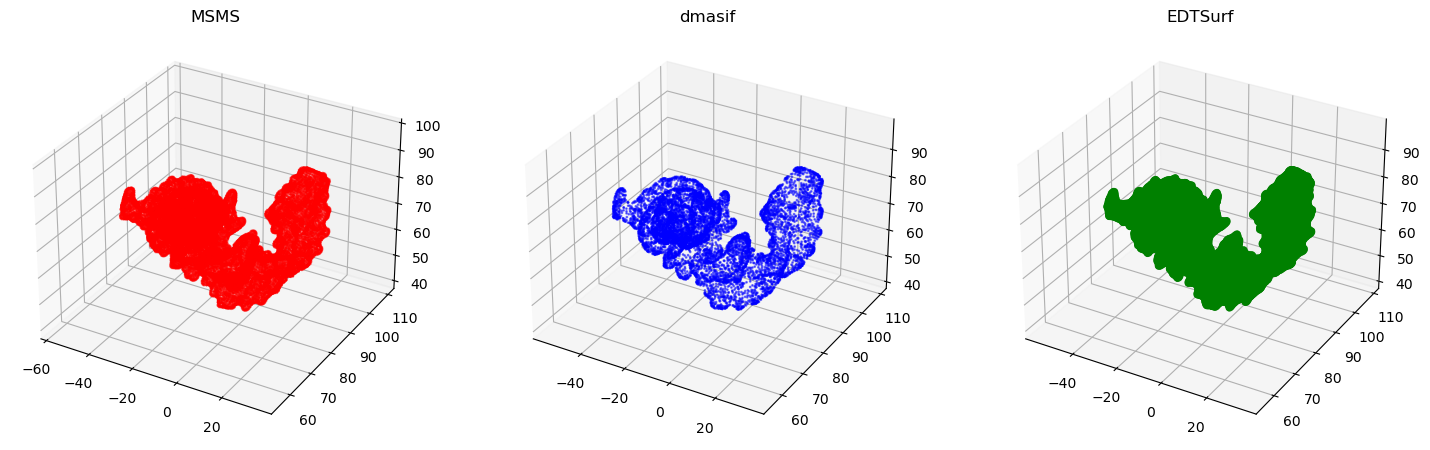

In [91]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*edt_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('EDTSurf')

fig.show()

print('MSMS point number:', msms_vert.shape[0])
print('dmasif point number:', dmasif_vert.shape[0])
print('EDTSurf point number:', edt_vert.shape[0])

Рассчитаем лоссы, сравним способ dmasif с MSMS (будем считать МSMS золотым стандартом)

In [92]:
d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, torch.Tensor(msms_vert), dmasif_norm, torch.Tensor(msms_norm), single_directional=True)
d_haus_dist=hausdorff_distance(dmasif_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',d_ch_loss.item())
print('Normal distance:',d_norm_loss.item())
print('Hausdorff distance:',d_haus_dist.item())

Chamfer distance: 0.3386051654815674
Normal distance: 0.08630812168121338
Hausdorff distance: 3.516693115234375


In [93]:
msms_dist=distribution(torch.Tensor(msms_vert), reduction='max')
dmasif_dist=distribution(dmasif_vert, reduction='max')
print('MSMS distribution:',msms_dist.item())
print('dMaSIF distribution:',dmasif_dist.item())

[KeOps] Generating code for formula Sum_Reduction(Step(Var(2,1,2)-Sum((Var(0,3,0)-Var(1,3,1))**2)),0) ... OK
MSMS distribution: 19.218650817871094
dMaSIF distribution: 9.487260818481445


### Простой метод

Сделаем самую простую детскую модель, которая будет просто рисовать рандомные точки по SAS поверхности, удалять внутренние точки, перемещать точки на радиус пробы и усреднять грид кластерингом для получения условной SES поверхности. 

In [94]:
try:
    importlib.reload(sys.modules['simple_surface'])
except KeyError:
    pass
from simple_surface import get_simple_surface

In [95]:
my_vert, my_norm = get_simple_surface(pdb_file)


2186 3 300


Проблема: для получения приемлевого количества точек нужно генерировать по 300 точек на атом, что может создать ограничения по памяти. При этом большая часть этих точек в итоге никак не сыграет, а будет отфильтрована. Была сделана попытка генерировать и отфильтровывать точки символьными функциями, но keops не работает с таким количеством измерений. 

MSMS point number: 31228
dMaSIF point number: 8164
Mine point number: 8653


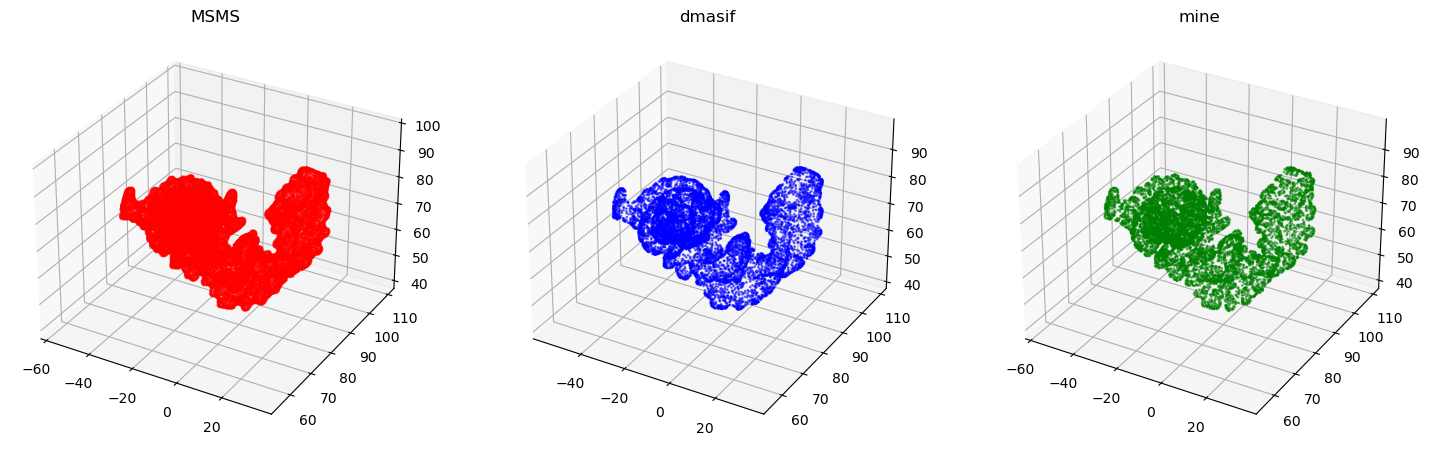

In [96]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*my_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('mine')

print('MSMS point number:', msms_vert.shape[0])
print('dMaSIF point number:', dmasif_vert.shape[0])
print('Mine point number:', my_vert.shape[0])


In [97]:
m_ch_loss, m_norm_loss=chamfer_distance( my_vert, torch.Tensor(msms_vert), my_norm, torch.Tensor(msms_norm), single_directional=True)
m_haus_dist=hausdorff_distance(my_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',m_ch_loss.item())
print('Normal distance:',m_norm_loss.item())
print('Hausdorff distance:',m_haus_dist.item())

my_dist=distribution(my_vert, reduction='max')
print('Distribution:',my_dist.item())

Chamfer distance: 0.26887452602386475
Normal distance: 0.02708578296005726
Hausdorff distance: 2.098378896713257
Distribution: 6.810123443603516


In [98]:
loss_col=chamfer_distance( my_vert, torch.Tensor(msms_vert),reduction=None)

fig=px.scatter_3d(x=my_vert[:,0],y=my_vert[:,1],z=my_vert[:,2], color=loss_col[0][0][:,0].log())
fig.update_traces(marker={'size': 2})
fig.update_layout(
    autosize=False, 
    width=1200, 
    height=800,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

In [99]:
pd.DataFrame(index=['dmasif','mine'], columns=['chamfer','normal','hausdorff','distribution'],
             data=[[d_ch_loss.item(),d_norm_loss.item(), d_haus_dist.item(), dmasif_dist.item()],
                   [m_ch_loss.item(),m_norm_loss.item(), m_haus_dist.item(), my_dist.item()]])

,chamfer,normal,hausdorff,distribution
dmasif,0.338605,0.086308,3.516693,9.487261
mine,0.268875,0.027086,2.098379,6.810123


Результаты детского метода сравнимы с методом dmasif

## Нейронки

Для расчета точек поверхности нейронок нет, значит, можно написать самостоятельно

### Датасет

Сделаем неизбыточную выборку структур макромолекул. Я брала так: искала в pdb "CASP target", фильтровала asymmetric units и кластеризовала по 30% сходству, получилось 2337 белков, не совпадающих с белками из предыдущих выборок для обучения masif. Также нашла в недрах интернета выборку из 2863 неизбыточных РНК (https://doi.org/10.1093/nargab/lqad040) и тоже досыпала в свой датасет. Все это могущество протонировала.

In [ ]:
# Download and protonate pdbs
'''
! mkdir protein_data/
! python3 download_pdb.py -pdb_list prot_nrd.txt
! python3 download_pdb.py -pdb_list rna_nrd_2.txt

'''

In [3]:
try:
    importlib.reload(sys.modules['data'])
except KeyError:
    pass
from data import AtomSurfaceDataset

In [4]:
dataset=AtomSurfaceDataset(list=[x.rstrip()+'.pdb' for x in open('prot_nrd.txt')][:30]) # пока возьмем 30 штук для отладки
dataset[0].keys()

100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


dict_keys(['atom_xyz', 'atom_rad', 'target_xyz', 'target_normals'])

In [5]:
train_set, val_set = torch.utils.data.random_split(dataset, [0.8,0.2])

Это класс для разбиения датасета на батчи

In [6]:
class CollateDict:
    """
       data: is a list of dicts 
       which is to be converted 
       to a dict of tensors 
       with new keys corresponding to batches
    """
    def __init__(self, follow_batch=['atom_xyz','target_xyz']):
        self.follow_batch=follow_batch

    def __call__(self, data):

        result_dict = {}
        for inc, dict_ in enumerate(data):
            for key, value in dict_.items():   
                if key not in result_dict:
                    result_dict[key] = value
                else:
                    result_dict[key] = torch.cat((result_dict[key], value), dim=0)
                if key in self.follow_batch:
                    batch=torch.full((value.shape[0],),inc) 
                    bkey=f'{key}_batch'      
                    if bkey not in result_dict:
                        result_dict[bkey] = batch
                    else:
                        result_dict[bkey] = torch.cat((result_dict[bkey], batch), dim=0)

        return result_dict

In [77]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=CollateDict())
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, collate_fn=CollateDict())

### Модель

In [113]:
import torch 
import torch.nn as nn
from pykeops.torch import LazyTensor
from batching import diagonal_ranges

Идея простая: генерируем случайные точки вокруг каждого атома, для каждой точки берем ближайшие к ней атомы, линейными слоями преобразуем и суммируем векторы до них, билинейным слоем комбинируем их с текущими нормалями, и результирующими векторами оптимизируем и нормаль, и положение точки. Делаем так несколько раз (хз, правда, как через это потом пойдет градиент). Также есть смутные сомнения в ротационной инвариантности.

In [155]:


def get_features_v(x, y, x_batch, y_batch, y_features, k=16, gamma=1):

    N, D = x.shape
    x_i = LazyTensor(x[:, None, :].contiguous())
    y_j = LazyTensor(y[None, :, :].contiguous())

    pairwise_distance_ij = ((x_i - y_j) ** 2).sum(-1)
    pairwise_distance_ij.ranges = diagonal_ranges(x_batch, y_batch)

    # N.B.: KeOps doesn't yet support backprop through Kmin reductions...
    # dists, idx = pairwise_distance_ij.Kmin_argKmin(K=k,axis=1)
    # So we have to re-compute the values ourselves:
    idx = pairwise_distance_ij.argKmin(K=k, axis=1).view(-1)  # (N, K)
    
    x_ik = y[idx,:].view(N, k, D)

    vecs=(x[:, None, :]-x_ik) # (N, K, D)   
    
    dists = (vecs ** 2).sum(-1)

    dists = torch.pow(dists+1e-8,-(1+gamma)/2) # (N, K)
    
    _, num_dims = y_features.size()

    #normalize coords by distance
    norm_vec=vecs*dists[:, :, None] #(N, k, D)
    
    feature = y_features[idx, :].view(N, k, num_dims)

    feature=norm_vec[:,:,:,None] * feature[:,:,None,:] # (N, k, D, num_dims )

    return torch.transpose(feature, 1, 3) # (N, num_dims, D, k )

class AtomShift(nn.Module):
    def __init__(self, in_dims, emb_dims, k=16, dropout=0):
        super(AtomShift, self).__init__()
        self.in_dims = in_dims
        self.emb_dims = emb_dims
        self.k = 16
        self.dropout=dropout

        self.transform_types = nn.Sequential(
            nn.Linear(self.in_dims,self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.dropout=nn.Dropout2d(self.dropout)

        self.bil=nn.Bilinear(self.emb_dims,1,self.emb_dims)

        self.emb = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, 2),
        )

    def forward(self, xyz, norm, atom_xyz, atomtypes, batch, atom_batch):

        if len(atomtypes.shape)<2:
            atomtypes=atomtypes[:,None]
        atomtypes = self.transform_types(atomtypes)
        fx = get_features_v(xyz, atom_xyz, batch, atom_batch, atomtypes, k=self.k)
        fx = self.dropout(fx).sum(-1) #(N, E, D)
        fx=torch.transpose(fx,1,2)
        fx=self.bil(fx, norm[:,:,None])
        fx=self.emb(fx)

        dxyz = fx[:,:,0]
        dnorm = fx[:,:,1]

        return dxyz, dnorm

class ModelHuel(nn.Module):

    def __init__(self, distance=1.05, sup_sampling=20, n_shifts=2):
        super(ModelHuel, self).__init__()

        self.distance=distance
        self.sup_sampling=sup_sampling
        self.n_shifts=n_shifts
        self.shift=AtomShift(in_dims=1, emb_dims=4)

    def init_points(self, prot):

        atoms=prot['atom_xyz']
        batch_atoms = prot['atom_xyz_batch']

        T = self.distance
        N, D = atoms.shape
        B = self.sup_sampling 

        batch_z = batch_atoms[:, None].repeat(1, B).view(N * B)
        r = 10 * T * torch.randn(N, B, D).type_as(atoms)
        z = (atoms[:, None, :] + r).view(-1, D) 
        norm = (r / (r**2).sum(1, keepdim=True).sqrt()).view(-1, D)
 
        prot['xyz']=z
        prot['normals']=norm
        prot['xyz_batch']=batch_z

    def forward(self, prot):
        if 'xyz' not in prot:
            self.init_points(prot)
        
        for _ in range(self.n_shifts):        
            dxyz, dnorm=self.shift(
                prot['xyz'],prot['normals'],
                prot['atom_xyz'],prot['atom_rad'],
                prot['xyz_batch'],prot['atom_xyz_batch'])
            prot['xyz'],prot['normals']=dxyz, dnorm
        
        return prot

In [156]:
try:
    importlib.reload(sys.modules['losses'])
except KeyError:
    pass
from losses import SurfaceCriterion


Обучим модель

In [157]:
model=ModelHuel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = SurfaceCriterion()
n_epochs=10
model.train()

for epoch in range(n_epochs):  # number of epochs
    training_loss = 0
    for i, data in tqdm(enumerate(train_loader, 0)): 
        optimizer.zero_grad()

        out = model(data)
        loss = criterion(out)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
    print(f'Training loss: {training_loss}')

print('Finished Training')


24it [00:17,  1.40it/s]


Training loss: 4661.282264709473


24it [00:20,  1.19it/s]


Training loss: 4658.283618927002


24it [00:15,  1.54it/s]


Training loss: 4654.187236785889


24it [00:15,  1.52it/s]


Training loss: 4648.263786315918


24it [00:16,  1.45it/s]


Training loss: 4637.995162963867


24it [00:15,  1.51it/s]


Training loss: 4625.413776397705


24it [00:15,  1.56it/s]


Training loss: 368252.5457305908


24it [00:15,  1.56it/s]


Training loss: 805288.0620727539


24it [00:16,  1.46it/s]


Training loss: 1005270.2198791504


24it [00:16,  1.44it/s]

Training loss: 954618.1999359131
Finished Training


In [153]:
torch.autograd.set_detect_anomaly(True)

Нихрена не обучается, надо бы оптимизировать гиперпараметры, повставлять всякие нормализации, уточнить лоссы.

MSMS point number: 46069
Mine point number: 111580


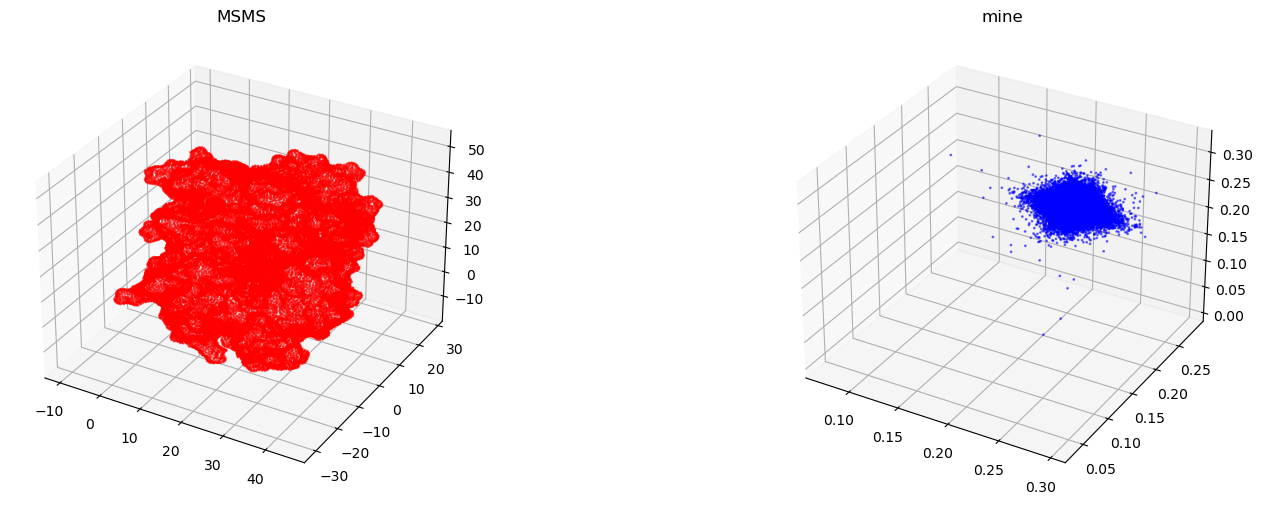

In [145]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(*out['target_xyz'].detach().numpy().T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*out['xyz'].detach().numpy().T, s=1, color='blue',alpha=0.5)
ax.set_title('mine')


print('MSMS point number:', out['target_xyz'].shape[0])
print('Mine point number:', out['xyz'].shape[0])


## Способы триангуляции

Это пока не нужно

In [ ]:
import numpy as np
import k3d
from compute_triangles import split_triangles, delaunay

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#cells=split_triangles(my_vert)
cells=delaunay(my_vert)

In [ ]:
plot = k3d.plot()
plot+=k3d.points(my_vert, point_size=0.2, shader='flat')
plot+=k3d.mesh(my_vert,cells, side='double', color=0x32ff31)

plot.display()

Output()